In [1]:
%%capture 
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Enabaling GPU

In [2]:
# https://youtu.be/UcHe0xiuvpg
# https://youtu.be/6pUSZgPJ3Yg
# https://youtu.be/my7LEgYTJto
"""
pix2pix GAN model
Based on the code by Jason Brownlee from his blogs on https://machinelearningmastery.com/
I seriously urge everyone to foloow his blogs and get enlightened. 
I am adapting his code to various applications but original credit goes to Jason.
    Original paper: https://arxiv.org/pdf/1611.07004.pdf
    Github for original paper: https://phillipi.github.io/pix2pix/
    
Generator:    
The encoder-decoder architecture consists of:
encoder:
C64-C128-C256-C512-C512-C512-C512-C512
decoder:
CD512-CD512-CD512-C512-C256-C128-C64
Discriminator
C64-C128-C256-C512
After the last layer, a convolution is applied to map to
a 1-dimensional output, followed by a Sigmoid function.    
"""
# 
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
print('done!')

done!


In [3]:
import tensorflow as tf

In [4]:

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2022-07-28 21:21:59.530308: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-28 21:21:59.601856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 21:21:59.742528: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 21:21:59.743396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [5]:


#############################################################################
#Define generator, discriminator, gan and other helper functions
#We will use functional way of defining model and not sequential
#as we have multiple inputs; both images and corresponding labels. 
########################################################################

#Since pix2pix is a conditional GAN, it takes 2 inputs - image and corresponding label
#For pix2pix the label will be another image. 

# define the standalone discriminator model
#Given an input image, the Discriminator outputs the likelihood of the image being real.
    #Binary classification - true or false (1 or 0). So using sigmoid activation.
#Think of discriminator as a binary classifier that is classifying images as real/fake.

# From the paper C64-C128-C256-C512
#After the last layer, conv to 1-dimensional output, followed by a Sigmoid function.  

def define_discriminator(image_shape,target_shape):
    
	# weight initialization
	init = RandomNormal(stddev=0.02) #As described in the original paper
    
	# source image input
	in_src_image = Input(shape=image_shape)  #Image we want to convert to another image
	# target image input
	in_target_image = Input(shape=target_shape)  #Image we want to generate after training.   #MOIEN
    
	# concatenate images, channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
    
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2 
    
    
#     # Not in the original paper. Comment this block if you want.
# 	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
# 	d = BatchNormalization()(d)
# 	d = LeakyReLU(alpha=0.2)(d)

	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
    
    
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
    #The model is trained with a batch size of one image and Adam opt. 
    #with a small learning rate and 0.5 beta. 
    #The loss for the discriminator is weighted by 50% for each model update.
    
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# disc_model = define_discriminator((256,256,3))
# plot_model(disc_model, to_file='disc_model.png', show_shapes=True)

##############################
#Now define the generator - in our case we will define a U-net
# define an encoder block to be used in generator
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    print(g.shape)
    return g

# define a decoder block to be used in generator
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    print(g.shape)
    return g

# define the standalone generator model - U-net
def define_generator(image_shape=(64,64,7)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)

	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e5)
	b = Activation('relu')(b)
	# decoder model: CD512-CD512-CD512-C512-C256-C128-C64
	d3 = decoder_block(b, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
    
    
    ########
    #######
    #####
    
#     g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified 
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified                      #3 is for 3 channel output change if eslwise
	out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
	# define model
	model = Model(in_image, out_image)
	return model

# gen_model = define_generator((256,256,3))
# plot_model(gen_model, to_file='gen_model.png', show_shapes=True)


# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but 
                                                #standalone descriminator will be trainable.
            
	# define the source image
	in_src = Input(shape=image_shape)
	# suppy the image as input to the generator 
	gen_out = g_model(in_src)
	# supply the input image and generated image as inputs to the discriminator
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and disc. output as outputs
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
    
    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    #Authors suggested weighting BCE vs L1 as 1:100.
	model.compile(loss=['binary_crossentropy', 'mae'], 
               optimizer=opt, loss_weights=[1,100])
	return model

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# generate samples and save as a plot and save the model
#GAN models do not converge, we just want to find a good balance between
#the generator and the discriminator. Therefore, it makes sense to periodically
#save the generator model and check how good the generated image looks. 
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i][:,:,0:3])                         #MOIEN
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i][:,:,0:3])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i][:,:,0:3])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
    # save the generator model
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=20, n_batch=1,save_h5_every_n_epoc=5):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    print('bat_per_epo: ',bat_per_epo)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    gl_list = []                              #MOIEN
    dl1_list = []
    dl2_list = []
    x_label = []
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        if (i) % 100 ==0:
            print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        #if (i+1) % (bat_per_epo * 10) == 0:

        if (i+1) % (bat_per_epo) == 0:
            print(f'epoc {(i+1)/bat_per_epo} was done!' )
            gl_list.append(g_loss)
            dl1_list.append(d_loss1)
            dl2_list.append(d_loss2)
            x_label.append(i+1/bat_per_epo)
        if (i+1) % (bat_per_epo*save_h5_every_n_epoc) == 0:
            summarize_performance(i, g_model, dataset)
    return {'g_loss':gl_list,'d_loss1':dl1_list,'d_loss2':dl2_list,'x_label':x_label}   #MOIEN
print('done!')

done!


In [6]:
from os import listdir
from numpy import asarray, load
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np
from skimage import io

In [7]:
def stacker(input_path,SIZE = (64,64) , reverse_dim = False):
  files = os.listdir(input_path)
  files.sort()

  x =[]
  IPATH = input_path + '//'
  for i in (files):
    img = io.imread(IPATH+str(i))
    if reverse_dim:
        img = np.swapaxes(img, 2,0)
        img= np.swapaxes(img, 1,0)
    x.append(img)
    
    
  stacked = np.stack(x,axis=0)
  return stacked
print('done!')

done!


In [8]:
swir = stacker('../input/swir-to-vis/data/train/swir',reverse_dim=True)

In [9]:
vis = stacker('../input/swir-to-vis/data/train/vis')

In [10]:
print(swir.shape)
print(vis.shape)

(590, 64, 64, 7)
(590, 64, 64, 3)


In [11]:
print(swir.dtype)

int32


In [12]:
plt.rcParams['figure.figsize'] = [10,5]

In [13]:
smaple_num = 500

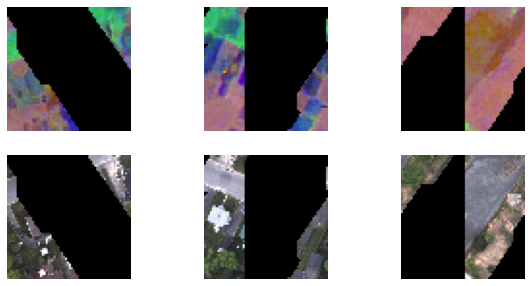

In [14]:
smaple_num += 3
n_samples = 3
for i,j in zip(range(smaple_num,smaple_num+n_samples),range(n_samples)):
	pyplot.subplot(2, n_samples, 1 + j)
	pyplot.axis('off')
	pyplot.imshow(swir[i,:,:,0:3].astype('uint8'))
# plot target image
for i,j in zip(range(smaple_num,smaple_num+n_samples),range(n_samples)):
	pyplot.subplot(2, n_samples, 1 + n_samples + j)
	pyplot.axis('off')
	pyplot.imshow(vis[i].astype('uint8'))
pyplot.show()

In [15]:
# def load_images(swir_path,vis_path):
# 	src_list, tar_list = list(), list()
# 	# enumerate filenames in directory, assume all are images
# 	for filename in listdir(path):
# 		# load and resize the image
# 		pixels = load_img(path + filename, target_size=size)
# 		# convert to numpy array
# 		pixels = img_to_array(pixels)
# 		# split into satellite and map
# 		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
# 		src_list.append(sat_img)
# 		tar_list.append(map_img)
# 	return [asarray(src_list), asarray(tar_list)]

In [16]:
image_shape = swir.shape[1:]
target_shape = vis.shape[1:]
# define the models
d_model = define_discriminator(image_shape,target_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

#Define data
# load and prepare training images
data = [swir, vis]

def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

2022-07-28 21:22:10.863939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 21:22:10.864919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 21:22:10.865679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 21:22:10.866596: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 21:22:10.867274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

(None, 32, 32, 64)
(None, 16, 16, 128)
(None, 8, 8, 256)
(None, 4, 4, 512)
(None, 2, 2, 512)
(None, 2, 2, 1024)
(None, 4, 4, 1024)
(None, 8, 8, 512)
(None, 16, 16, 256)
(None, 32, 32, 128)


In [17]:
dataset = preprocess_data(data)

In [18]:
print(np.max(dataset[0][0]))
print(np.min(dataset[0][0]))
print(np.mean(dataset[0][0]))
print(np.std(dataset[0][0]))

1.0
-1.0
-0.2288400516456583
0.46287075643660675


In [19]:
from datetime import datetime 
start1 = datetime.now() 

losses = train(d_model, g_model, gan_model, dataset, n_epochs=20, n_batch=1,save_h5_every_n_epoc=5) 
#Reports parameters for each batch (total 1096) for each epoch.
#For 10 epochs we should see 10960

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

#Reports parameters for each batch (total 1096) for each epoch.
#For 10 epochs we should see 10960

bat_per_epo:  590


2022-07-28 21:22:11.931117: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-28 21:22:13.097930: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


>1, d1[0.397] d2[0.655] g[53.539]
>101, d1[0.431] d2[0.466] g[19.430]
>201, d1[0.368] d2[0.399] g[26.962]


2022-07-28 21:22:48.503857: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:22:49.347024: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:22:49.447254: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:22:49.980646: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:22:50.082009: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:22:50.095949: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:22:50.223815: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:22:50.324167: W tensorflow/core/data/root_dataset.cc:16

>301, d1[0.675] d2[0.126] g[27.689]
>401, d1[0.030] d2[0.367] g[28.504]
>501, d1[0.218] d2[0.070] g[35.058]
epoc 1.0 was done!
>601, d1[0.668] d2[0.267] g[24.441]
>701, d1[0.308] d2[0.119] g[31.155]
>801, d1[0.032] d2[0.058] g[25.332]
>901, d1[0.244] d2[0.154] g[33.961]


2022-07-28 21:23:52.951855: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:23:55.322467: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1001, d1[0.063] d2[0.047] g[30.932]
>1101, d1[0.243] d2[0.049] g[46.878]
epoc 2.0 was done!
>1201, d1[0.075] d2[0.099] g[18.408]
>1301, d1[0.125] d2[0.226] g[11.171]


2022-07-28 21:24:26.584058: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:24:26.600077: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1401, d1[0.054] d2[0.081] g[34.784]


2022-07-28 21:24:38.753373: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1501, d1[0.309] d2[0.095] g[22.451]


2022-07-28 21:24:49.728259: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1601, d1[0.005] d2[0.081] g[28.435]


2022-07-28 21:24:58.403714: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:24:58.527506: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:24:58.931998: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:24:59.029339: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:24:59.044000: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:24:59.160355: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1701, d1[0.189] d2[0.380] g[11.910]
epoc 3.0 was done!
>1801, d1[1.278] d2[0.085] g[29.176]


2022-07-28 21:25:22.455651: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1901, d1[0.101] d2[0.113] g[24.101]


2022-07-28 21:25:30.850756: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:25:30.865866: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:25:33.735314: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>2001, d1[0.125] d2[0.154] g[27.599]
>2101, d1[0.705] d2[0.209] g[27.112]
>2201, d1[0.015] d2[0.019] g[34.141]
>2301, d1[0.514] d2[0.182] g[18.249]


2022-07-28 21:26:02.350598: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:26:02.955645: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoc 4.0 was done!
>2401, d1[0.036] d2[0.034] g[27.744]
>2501, d1[0.093] d2[0.099] g[30.649]
>2601, d1[0.189] d2[0.184] g[11.945]


2022-07-28 21:26:34.122371: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:26:34.660903: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:26:34.769719: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:26:34.784531: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:26:39.605295: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>2701, d1[0.109] d2[0.079] g[30.986]
>2801, d1[0.023] d2[0.049] g[30.753]
>2901, d1[0.081] d2[0.126] g[25.518]


2022-07-28 21:27:01.437906: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoc 5.0 was done!
>Saved: plot_002950.png and model_002950.h5


2022-07-28 21:27:06.332522: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:27:07.003546: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:27:07.126476: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>3001, d1[0.021] d2[0.038] g[26.143]
>3101, d1[0.568] d2[0.209] g[14.199]


2022-07-28 21:27:23.615452: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>3201, d1[0.039] d2[0.072] g[30.907]


2022-07-28 21:27:34.219452: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:27:38.858251: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:27:38.873482: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:27:39.424884: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:27:39.552190: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:27:39.693021: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:27:39.810938: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:27:39.948346: W tensorflow/core/data/root_dataset.cc:16

>3301, d1[0.012] d2[0.139] g[23.991]
>3401, d1[0.055] d2[0.027] g[21.315]
>3501, d1[0.028] d2[0.025] g[20.870]
epoc 6.0 was done!
>3601, d1[0.207] d2[0.126] g[19.988]


2022-07-28 21:28:12.039292: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:28:12.390592: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:28:18.475882: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>3701, d1[0.195] d2[0.066] g[22.202]
>3801, d1[0.175] d2[0.094] g[27.837]


2022-07-28 21:28:29.573009: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>3901, d1[0.065] d2[0.134] g[15.358]


2022-07-28 21:28:44.081185: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:28:44.210258: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>4001, d1[0.524] d2[0.047] g[18.914]
>4101, d1[0.038] d2[0.081] g[23.719]
epoc 7.0 was done!


2022-07-28 21:29:02.487605: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>4201, d1[0.164] d2[0.144] g[15.787]


2022-07-28 21:29:13.441772: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:29:15.968839: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:29:16.462579: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>4301, d1[0.033] d2[0.142] g[19.218]
>4401, d1[0.253] d2[0.149] g[19.208]


2022-07-28 21:29:35.402664: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:29:35.421846: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>4501, d1[0.134] d2[0.375] g[26.490]
>4601, d1[0.079] d2[0.125] g[27.423]


2022-07-28 21:29:46.435803: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:29:46.452147: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:29:46.567660: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:29:46.585128: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:29:47.439376: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>4701, d1[0.026] d2[0.049] g[30.404]
epoc 8.0 was done!
>4801, d1[0.075] d2[0.036] g[24.680]


2022-07-28 21:30:08.369828: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>4901, d1[0.163] d2[0.152] g[14.420]


2022-07-28 21:30:19.137412: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:30:19.297146: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>5001, d1[0.025] d2[0.049] g[27.729]
>5101, d1[0.091] d2[0.057] g[25.985]


2022-07-28 21:30:41.221438: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:30:41.544965: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>5201, d1[0.047] d2[0.081] g[17.411]


2022-07-28 21:30:51.591542: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:30:51.860563: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:30:52.092985: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:30:52.691828: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>5301, d1[0.019] d2[0.287] g[16.191]
epoc 9.0 was done!
>5401, d1[0.034] d2[0.118] g[19.567]


2022-07-28 21:31:03.516447: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:31:03.664232: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>5501, d1[0.030] d2[0.153] g[18.037]
>5601, d1[0.204] d2[0.380] g[11.076]


2022-07-28 21:31:23.626242: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:31:23.729386: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:31:24.057168: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:31:24.166720: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:31:24.401330: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:31:24.416527: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:31:24.514882: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:31:24.529901: W tensorflow/core/data/root_dataset.cc:16

>5701, d1[0.160] d2[0.316] g[18.167]
>5801, d1[0.043] d2[0.119] g[15.571]
epoc 10.0 was done!
>Saved: plot_005900.png and model_005900.h5
>5901, d1[0.013] d2[0.118] g[18.902]


2022-07-28 21:31:55.248954: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:31:55.400311: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:31:56.123139: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:31:58.483055: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:31:58.502997: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>6001, d1[0.093] d2[0.124] g[21.025]
>6101, d1[0.030] d2[0.144] g[18.976]


2022-07-28 21:32:20.468790: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:32:20.485677: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>6201, d1[0.040] d2[0.051] g[14.182]


2022-07-28 21:32:22.669356: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:32:27.466723: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:32:28.033832: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:32:28.048051: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:32:28.165846: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>6301, d1[0.055] d2[0.080] g[20.784]


2022-07-28 21:32:31.590948: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>6401, d1[0.841] d2[0.301] g[5.366]
epoc 11.0 was done!
>6501, d1[0.060] d2[0.057] g[20.015]
>6601, d1[0.111] d2[0.359] g[13.222]


2022-07-28 21:33:00.563847: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:33:00.668749: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:33:00.786882: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>6701, d1[0.390] d2[0.220] g[19.402]
>6801, d1[0.043] d2[0.344] g[21.670]
>6901, d1[0.164] d2[0.138] g[16.514]


2022-07-28 21:33:32.826500: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:33:32.846293: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:33:33.160711: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:33:33.699106: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:33:33.716632: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>7001, d1[0.108] d2[0.153] g[17.635]
epoc 12.0 was done!


2022-07-28 21:33:48.538014: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:33:48.552990: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>7101, d1[0.073] d2[0.108] g[17.935]
>7201, d1[0.043] d2[0.106] g[17.826]


2022-07-28 21:34:06.379630: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:34:06.397094: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:34:06.677747: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:34:06.778566: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:34:06.793905: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>7301, d1[0.412] d2[0.285] g[10.585]


2022-07-28 21:34:10.400867: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:34:10.417562: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>7401, d1[0.133] d2[0.355] g[19.867]


2022-07-28 21:34:21.501691: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>7501, d1[0.349] d2[0.196] g[15.545]


2022-07-28 21:34:32.542061: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>7601, d1[0.204] d2[0.623] g[8.377]


2022-07-28 21:34:39.023330: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:34:39.757588: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:34:39.883462: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:34:39.898263: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:34:43.314965: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoc 13.0 was done!
>7701, d1[0.038] d2[0.254] g[24.760]
>7801, d1[0.109] d2[0.097] g[23.656]


2022-07-28 21:35:05.546866: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>7901, d1[0.254] d2[0.316] g[14.267]


2022-07-28 21:35:11.800909: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:35:12.368699: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>8001, d1[0.262] d2[0.274] g[16.054]
>8101, d1[0.143] d2[0.447] g[15.623]
>8201, d1[0.150] d2[0.170] g[11.383]


2022-07-28 21:35:38.331895: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoc 14.0 was done!
>8301, d1[0.026] d2[0.115] g[20.232]


2022-07-28 21:35:44.787314: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:35:45.054946: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:35:45.306998: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:35:45.333843: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:35:45.590396: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:35:45.735321: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>8401, d1[0.303] d2[0.612] g[6.326]
>8501, d1[0.549] d2[0.336] g[11.662]
>8601, d1[0.409] d2[0.081] g[16.315]


2022-07-28 21:36:18.189872: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:36:18.481968: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:36:22.431962: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>8701, d1[0.040] d2[0.076] g[25.973]
>8801, d1[0.209] d2[0.204] g[11.565]
epoc 15.0 was done!
>Saved: plot_008850.png and model_008850.h5


2022-07-28 21:36:39.154770: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>8901, d1[0.119] d2[0.082] g[15.303]


2022-07-28 21:36:44.798978: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:36:52.009845: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9001, d1[0.402] d2[0.343] g[7.735]
>9101, d1[0.297] d2[0.460] g[16.427]
>9201, d1[0.357] d2[0.291] g[8.993]
>9301, d1[0.182] d2[0.251] g[11.385]


2022-07-28 21:37:23.767426: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:37:23.914775: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:37:24.194610: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:37:24.416065: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:37:28.501327: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9401, d1[0.260] d2[0.228] g[16.507]
epoc 16.0 was done!


2022-07-28 21:37:39.378816: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:37:39.540959: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9501, d1[0.426] d2[0.465] g[15.460]


2022-07-28 21:37:50.371032: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9601, d1[0.145] d2[0.170] g[13.981]


2022-07-28 21:37:57.319897: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:37:57.336211: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:37:57.440246: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:37:57.455714: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:37:57.627916: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:37:57.735895: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:37:57.859327: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:38:01.404677: W tensorflow/core/data/root_dataset.cc:16

>9701, d1[0.102] d2[0.218] g[16.846]
>9801, d1[0.304] d2[0.428] g[7.794]
>9901, d1[0.108] d2[0.684] g[18.039]


2022-07-28 21:38:23.426075: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:38:23.441059: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10001, d1[0.399] d2[0.457] g[16.104]
epoc 17.0 was done!
>10101, d1[0.405] d2[0.508] g[5.496]
>10201, d1[0.615] d2[0.158] g[19.737]
>10301, d1[0.273] d2[0.269] g[15.686]


2022-07-28 21:39:03.093459: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:39:03.395336: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10401, d1[0.538] d2[0.568] g[12.361]
>10501, d1[0.270] d2[0.124] g[11.059]
>10601, d1[0.221] d2[0.103] g[16.019]


2022-07-28 21:39:29.225092: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoc 18.0 was done!


2022-07-28 21:39:36.685557: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:39:37.084364: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:39:37.098739: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:39:37.217349: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:39:37.316674: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:39:37.331658: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10701, d1[0.068] d2[0.232] g[12.613]
>10801, d1[0.217] d2[0.281] g[14.287]
>10901, d1[0.615] d2[0.266] g[7.355]


2022-07-28 21:40:02.470881: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>11001, d1[0.154] d2[0.090] g[14.599]


2022-07-28 21:40:09.667016: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:40:10.397164: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:40:10.496535: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:40:10.512665: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:40:13.558177: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>11101, d1[0.201] d2[0.146] g[15.400]
>11201, d1[0.139] d2[0.202] g[15.433]
epoc 19.0 was done!
>11301, d1[0.168] d2[0.602] g[8.589]


2022-07-28 21:40:42.584251: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:40:42.856043: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:40:42.880854: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:40:43.216481: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:40:43.230901: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:40:43.328007: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:40:43.342589: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>11401, d1[0.147] d2[0.433] g[17.224]


2022-07-28 21:40:46.394971: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>11501, d1[0.389] d2[0.288] g[11.429]
>11601, d1[0.301] d2[0.273] g[13.510]
>11701, d1[0.217] d2[0.422] g[7.015]


2022-07-28 21:41:16.024742: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:41:16.494968: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-28 21:41:19.440398: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoc 20.0 was done!
>Saved: plot_011800.png and model_011800.h5
Execution time is:  0:19:09.405283


In [20]:
print(losses['g_loss'])

[24.748838424682617, 23.788982391357422, 33.00902557373047, 32.769378662109375, 20.99362564086914, 20.326316833496094, 14.685758590698242, 19.009809494018555, 20.494958877563477, 11.82708740234375, 6.307821273803711, 18.699718475341797, 9.045857429504395, 19.706626892089844, 11.997990608215332, 18.95684242248535, 18.6142635345459, 10.78292465209961, 16.056398391723633, 18.228017807006836]


In [21]:
import matplotlib.pyplot as plt

```
{'g_loss':gl_list,'d_loss1':dl1_list,'d_loss2':dl2_list,'x_label':x_lable} 
```

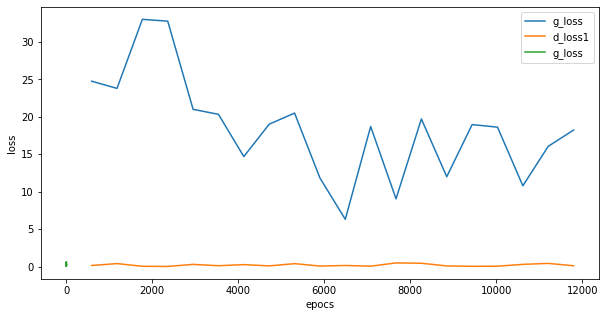

In [22]:
plt.plot(losses['x_label'],losses['g_loss'] ,  label='g_loss')
plt.plot(losses['x_label'],losses['d_loss1'],  label='d_loss1')
plt.plot(losses['d_loss2'],losses['d_loss2'],  label='g_loss')
plt.legend()
plt.xlabel("epocs")
plt.ylabel("loss")
plt.show()

In [23]:
from keras.models import load_model
from numpy.random import randint
# model = load_model('./model_005900.h5')
# model = load_model('./model_011800.h5')
# model = load_model('./model_014750.h5')
# model = load_model('./model_020650.h5')
# model = load_model('./model_038350.h5')
model = load_model('./model_011800.h5')


In [24]:

# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img , title=''):
    src_img = src_img[:,:,:,0:3]                     ##MOIEN
    images = vstack((src_img, gen_img, tar_img))
    # scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']
    # plot images row by row
    for i in range(len(images)):
        # define subplot
        pyplot.subplot(1, 3, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(images[i][:,:,0:3])
        # show title
        pyplot.title(titles[i])
    pyplot.suptitle(title)
    pyplot.show()


plt.rcParams['figure.figsize'] = [10,5]plt.rcParams['figure.figsize'] = [10,5]# Resulats on Training Data

In [25]:
plt.rcParams['figure.figsize'] = [10,3.5]

(590, 64, 64, 7)
sample number:  [75]


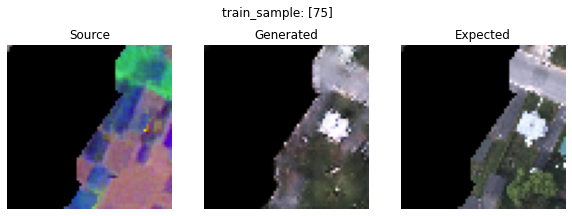

In [26]:
[X1, X2] = dataset
# select random example
print(X1.shape)
ix = randint(0, len(X1), 1)
print('sample number: ',ix)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image,title='train_sample: '+str(ix))

In [27]:
val_swir = stacker('../input/swir-to-vis/data/val/swir',reverse_dim=True)
val_vis = stacker('../input/swir-to-vis/data/val/vis')


# load and prepare training images
val_data = [val_swir, val_vis]

def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
val_dataset = preprocess_data(val_data)

# Resaults on test data

In [28]:
ix = [-1]

sample number:  [0]


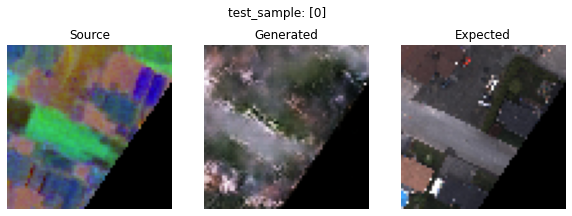

In [29]:
[X1, X2] = val_dataset
# select random example
# ix = randint(0, len(X1), 1)
ix[0] += 1
print('sample number: ',ix)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image,title='test_sample: '+str(ix))

In [30]:
from IPython.display import FileLink
FileLink(r'./model_005900.h5')

/kaggle/working/model_005900.h5

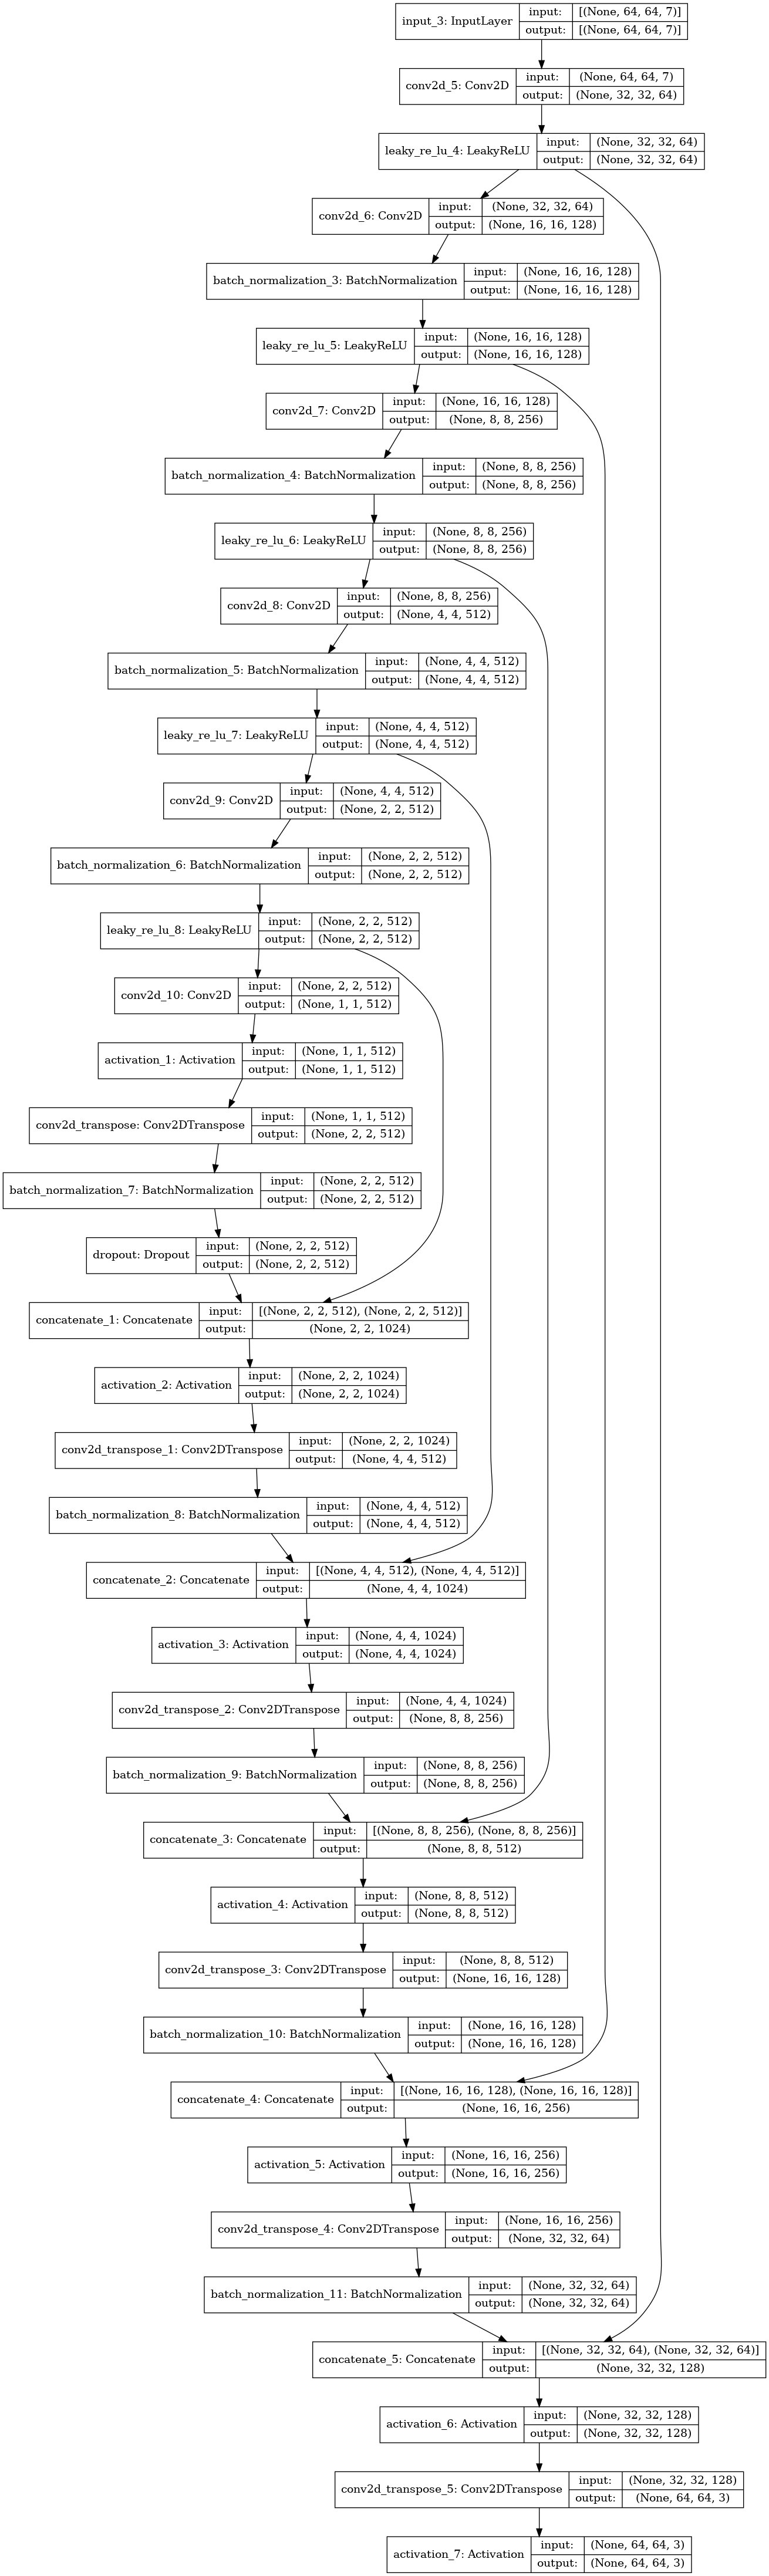

In [31]:
tf.keras.utils.plot_model(g_model, show_shapes=True)

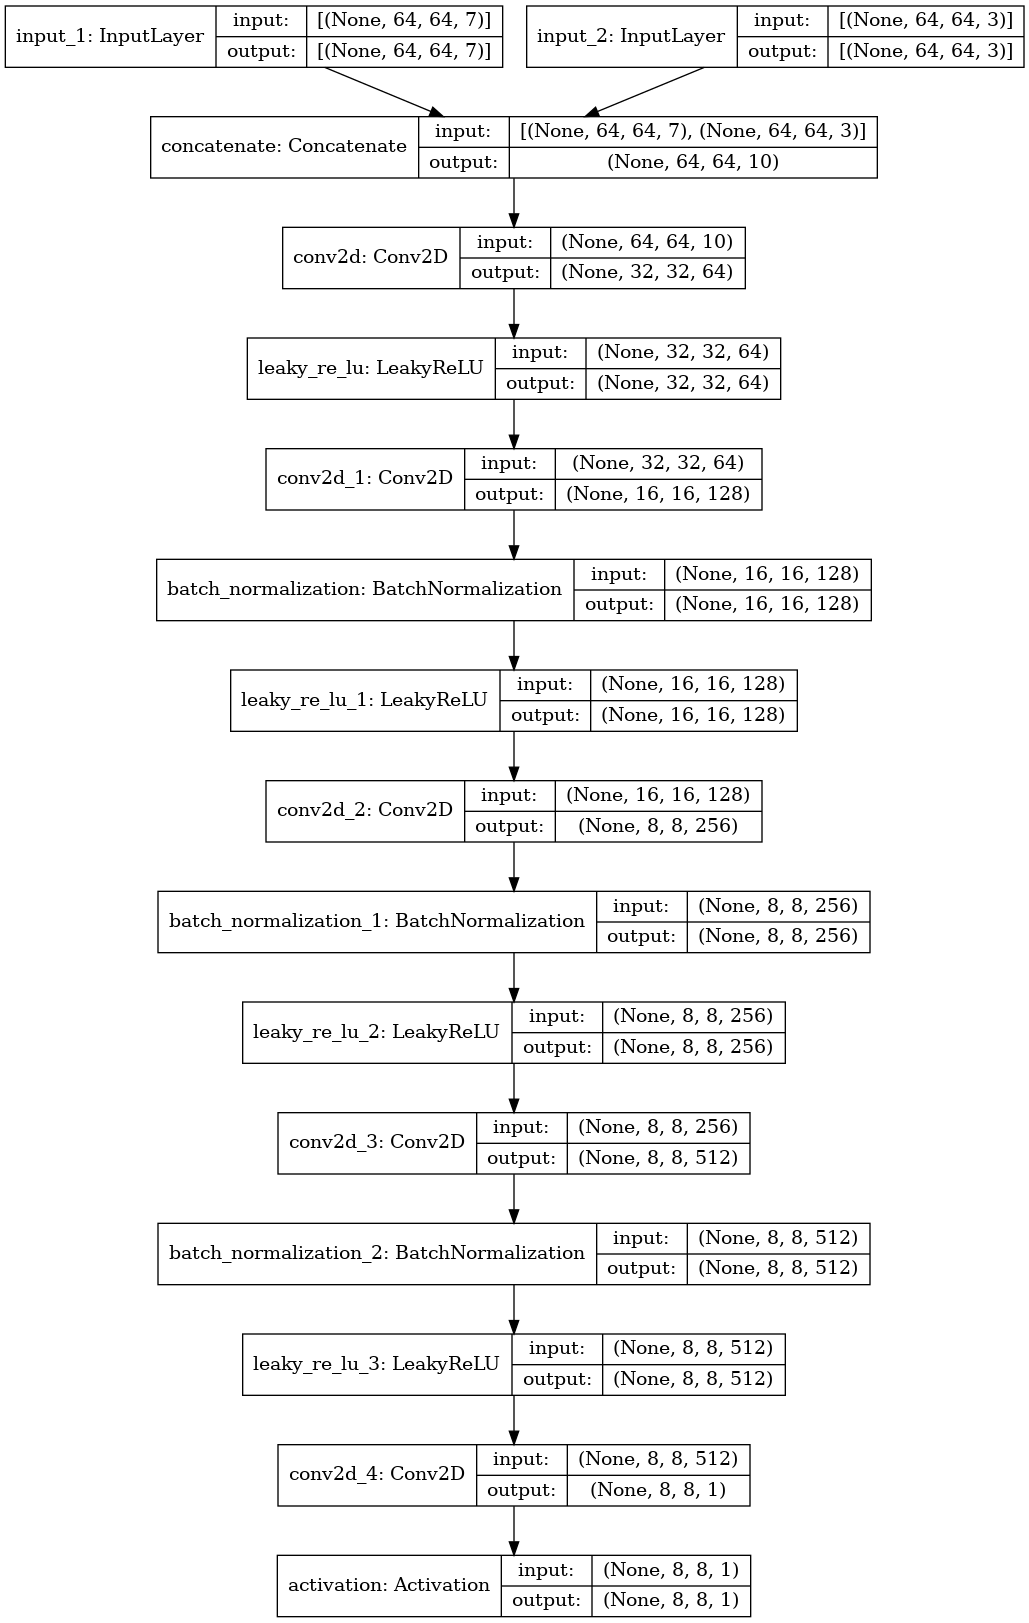

In [32]:
tf.keras.utils.plot_model(d_model, show_shapes=True)

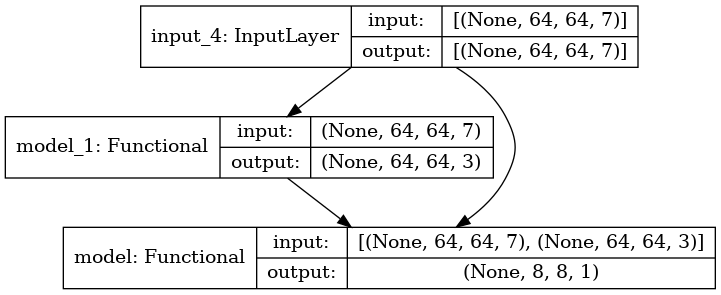

In [33]:
tf.keras.utils.plot_model(gan_model, show_shapes=True)

In [34]:
!pip freeze > requirements.txt